In [1]:
from ephys_queries import select_spike_times, select_ifr, select_waveforms, select_neurons
from ephys_queries import db_setup_core
import dotenv

In [2]:
from spiketimes.df import mean_firing_rate_ifr_by_neuron, cv2_by_neuron
from spiketimes.df import waveform_peaks_by_neuron, waveform_width_by_neuron, peak_asymmetry_by_neuron

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette("Set2")

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

### Select Raw Data

In [5]:
group_names = ["citalopram_continuation", "chronic_saline", "citalopram_discontinuation", 
               "chronic_citalopram", "chronic_saline_"]
block_name = "pre"

dotenv.load_dotenv()
engine, metadata = db_setup_core()

ifr = select_ifr(engine, metadata, 
                 block_name=block_name, 
                 group_names=group_names)
spiketimes = select_spike_times(engine, metadata, 
                                 block_name=block_name, 
                                 group_names=group_names)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons### Select Raw Data = select_neurons(engine, metadata, group_names=group_names)

### Engineer Features

In [6]:
mfr = mean_firing_rate_ifr_by_neuron(ifr)
cv2 = cv2_by_neuron(spiketimes, spiketimes_col="spike_time_samples")

peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

/home/rory/anaconda3/envs/ssri/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rory/anaconda3/envs/ssri/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Merge and Select Features For Clustering

In [7]:
df = pd.merge(mfr, cv2)
df1 = pd.merge(df, width).pipe(lambda x: pd.merge(x, peak_asym))  # for later merging

### Apply Exclusion Criteria

In [13]:
df2 = df[(df["mean_firing_rate"] > 0.5) & (df["cv2_isi"] < 1.2)].copy().dropna()

### Load Clustered Data

In [14]:
data_dir = Path(".").absolute().parent / "data"
df_acute = pd.read_csv(data_dir / "acute_baseline.csv")
df_acute = df_acute[df_acute["cluster"] != "no_baseline"]### Classify Data

### Classify Data

In [15]:
y_train = df_acute["cluster"].values
X_train = df_acute[["mean_firing_rate", "cv2_isi"]].values

X_test = df2[["mean_firing_rate", "cv2_isi"]].values

le = LabelEncoder()
y_train = le.fit_transform(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
### Cluster Data
model = SVC(kernel='rbf', C=1E6)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
df2["type"] = le.inverse_transform(y_hat) 

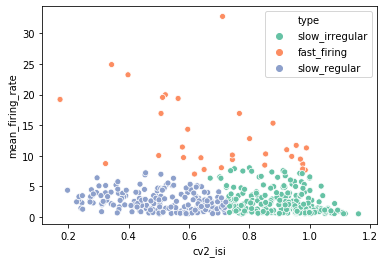

In [16]:
sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="type")
plt.show()

### Merge and Save Data

In [21]:
df_baseline = (df2
    .pipe(lambda x: pd.merge(x, df1, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
df_baseline["neuron_id"] = df_### Merge and Save Databaseline["neuron_id"].fillna(df_baseline["id"])
df_baseline["type"] = df_baseline["type"].fillna("no_baseline")
df_baseline = df_baseline.drop(["recording_session_id", "cluster_id", "id"], axis=1)

df_baseline.to_csv(data_dir / "chronic_baseline.csv")